# EECE 798K Project
### Patient clustering through EEG Data

By Lama Hasbini and Tamara Al-Sadek

### 1. Necessary Imports

This section imports all required Python libraries for EEG data analysis and clustering:
- **os**: For file system operations to load data files
- **pandas** and **numpy**: For data manipulation and numerical operations
- **matplotlib** and **seaborn**: For creating visualizations
- **sklearn components**:
  - **StandardScaler**: For normalizing feature values
  - **KMeans**: For clustering algorithms
  - **silhouette_score**: For evaluating cluster quality
  - **PCA**: For dimensionality reduction to visualize high-dimensional data

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

### 2. Load needed data

1. **Slow Wave Activity (SWA) reports** containing:
   - SWA_0.6_1Hz: Slow wave activity in the 0.6-1Hz frequency band
   - SWA_0.6_4Hz: Slow wave activity in the 0.6-4Hz frequency band
   - Median_Power: Median power values across electrodes
   - All_Electrodes_Avg_Median: Average of median power across all electrodes
   - Frontal_Avg_Median: Average of median power across frontal electrodes only

2. **Spindle summary data** for each patient

The code organizes all data into a dictionary structure with patient IDs as keys, and then prints a summary of the loaded data for verification.

In [28]:
swa_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/Tamara Al-Sadek (Student)'s files - EECE798K Project/swa_reports_2"
spindle_folder = "/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/Tamara Al-Sadek (Student)'s files - EECE798K Project/spindle_summaries"

all_patient_data = {}

# Loop over all SWA report files
for filename in os.listdir(swa_folder):
    if filename.endswith("_epoched_SWA_Report.xlsx"):
        patient_id = filename.replace("_epoched_SWA_Report.xlsx", "")
        swa_file_path = os.path.join(swa_folder, filename)

        # Load the SWA data from 5 sheets
        swa_data = {
            'swa_0.6_1Hz': pd.read_excel(swa_file_path, sheet_name='SWA_0.6_1Hz'),
            'swa_0.6_4Hz': pd.read_excel(swa_file_path, sheet_name='SWA_0.6_4Hz'),
            'median_power': pd.read_excel(swa_file_path, sheet_name='Median_Power'),
            'all_electrodes_avg_median': pd.read_excel(swa_file_path, sheet_name='All_Electrodes_Avg_Median'),
            'frontal_avg_median': pd.read_excel(swa_file_path, sheet_name='Frontal_Avg_Median'),
        }

        # Attempt to load the corresponding spindle summary
        spindle_filename = f"{patient_id} pruned with ICA_SpDet_events_summary.xlsx"
        spindle_file_path = os.path.join(spindle_folder, spindle_filename)

        if os.path.exists(spindle_file_path):
            spindle_data = pd.read_excel(spindle_file_path)
        else:
            spindle_data = None
            print(f"Spindle summary not found for {patient_id}!")

        # Store both under patient_id
        all_patient_data[patient_id] = {
            'swa': swa_data,
            'spindles': spindle_data
        }
print(all_patient_data.keys()) 

for patient_id, data in all_patient_data.items():
    print(f"\n=== {patient_id} ===")
    print("SWA median power:\n", data['swa']['median_power'])
    if data['spindles'] is not None:
        print("Spindle summary:\n", data['spindles'].head())
    else:
        print("No spindle data.")

dict_keys(['49', '46', '37', '24', '64', '15', '73', '11', '63', '12', '27', '59', '74', '45', '34', '50', '5', '32', '43', '1', '76', '29', '18', '2', '31', '40', '6', '22', '13'])

=== 49 ===
SWA median power:
    Channel  MedianPower_0.6_1Hz  MedianPower_0.6_4Hz
0      Fp1            12.805099            33.586020
1       F7            10.001088            26.666407
2       T3             7.274065            21.771202
3       A1            10.108626            32.464888
4       T5             8.704999            23.918656
5       O1            11.041126            30.924999
6       F3             6.670770            21.909251
7       C3             4.994837            17.651926
8       P3             6.792353            21.109374
9       Fz             7.585432            25.044144
10      Cz            10.788224            37.224428
11      Pz             9.991632            29.520907
12     Fp2            13.385932            35.897940
13      F8            10.833107            29

### 3. EEG Feature Extraction from Slow Wave Activity and Spindle Summaries

This section extracts and processes features for patient clustering from both SWA data and spindle summaries:

1. **Feature extraction function** creates a consistent dataset by:
   - Extracting SWA metrics from all electrodes (0.6-1Hz and 0.6-4Hz bands)
   - Extracting SWA metrics specifically from frontal electrodes
   - Computing average spindle activity (slow, fast, and total spindles)
   - Combining all features into a uniform feature vector for each patient
   - Skipping patients with incomplete data

2. **Data normalization** using StandardScaler to ensure all features have equal weight in clustering

3. **Output verification** showing feature dimensions and scaled values for the first few patients

The resulting dataset contains 7 features per patient that capture EEG characteristics related to sleep patterns.

In [29]:
# Extract features for clustering
def extract_features(patient_data):
    features = []
    patient_ids = []
    
    for patient_id, data in patient_data.items():
        # Skip patients without complete data
        if data['spindles'] is None:
            continue
        
        # Extract SWA features from all_electrodes_avg_median
        swa_features = [
            data['swa']['all_electrodes_avg_median']['MeanMedianPower_0.6_1Hz'].values[0],
            data['swa']['all_electrodes_avg_median']['MeanMedianPower_0.6_4Hz'].values[0]
        ]
        
        # Extract SWA features from frontal_avg_median
        swa_features.extend([
            data['swa']['frontal_avg_median']['MeanMedianPower_0.6_1Hz'].values[0],
            data['swa']['frontal_avg_median']['MeanMedianPower_0.6_4Hz'].values[0]
        ])
        
        # Extract spindle features - average across channels
        # Filter the rows for different spindle metrics
        slow_spindle_row = data['spindles'][data['spindles']['Electrode'] == 'SlowSpindles']
        fast_spindle_row = data['spindles'][data['spindles']['Electrode'] == 'FastSpindles']
        total_spindle_row = data['spindles'][data['spindles']['Electrode'] == 'TotalSpindles']
        
        # Skip if we don't have all the spindle data types
        if len(slow_spindle_row) == 0 or len(fast_spindle_row) == 0 or len(total_spindle_row) == 0:
            continue
        
        # Get average values across all channels (excluding the 'Electrode' column)
        avg_slow_spindles = slow_spindle_row.iloc[:, 1:].values.mean()
        avg_fast_spindles = fast_spindle_row.iloc[:, 1:].values.mean()
        avg_total_spindles = total_spindle_row.iloc[:, 1:].values.mean()
        
        # Add spindle features
        spindle_features = [avg_slow_spindles, avg_fast_spindles, avg_total_spindles]
        
        # Combine all features
        combined_features = swa_features + spindle_features
        features.append(combined_features)
        patient_ids.append(patient_id)
    
    return np.array(features), patient_ids

# Extract features
X, patient_ids = extract_features(all_patient_data)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print feature names and shape
print(f"Number of patients with complete data: {len(patient_ids)}")
print(f"Feature array shape: {X.shape}")
print(f"Features: ['SWA_All_0.6_1Hz', 'SWA_All_0.6_4Hz', 'SWA_Frontal_0.6_1Hz', 'SWA_Frontal_0.6_4Hz', 'Avg_Slow_Spindles', 'Avg_Fast_Spindles', 'Avg_Total_Spindles']")
print("\nFirst few patients with their scaled features:")
for i in range(min(5, len(patient_ids))):
    print(f"Patient {patient_ids[i]}: {X_scaled[i]}")

Number of patients with complete data: 29
Feature array shape: (29, 7)
Features: ['SWA_All_0.6_1Hz', 'SWA_All_0.6_4Hz', 'SWA_Frontal_0.6_1Hz', 'SWA_Frontal_0.6_4Hz', 'Avg_Slow_Spindles', 'Avg_Fast_Spindles', 'Avg_Total_Spindles']

First few patients with their scaled features:
Patient 49: [-0.7819906  -0.76262048 -0.74203883 -0.72711636 -0.89741355  0.12111373
 -0.64960238]
Patient 46: [-1.04198581 -0.98595355 -1.02337104 -0.97330131  0.60782546  0.96120476
  1.04599782]
Patient 37: [ 0.24128133  0.90389185  0.14942392  0.68340639 -0.49355583  0.32773405
 -0.20557822]
Patient 24: [-0.08285348  0.66528843 -0.33289628  0.41226224 -0.71465628  0.31461923
 -0.3905763 ]
Patient 64: [ 2.22774797  2.80519709  1.85869484  2.40963333 -0.34215398 -0.89590369
 -0.79492722]


### 4. Determining Optimal Cluster Count Using Elbow Method and Silhouette Analysis

This section determines the optimal number of clusters using two complementary techniques:

1. **Elbow Method**: Plots Within-Cluster Sum of Squares (WCSS) against number of clusters (k)
   - WCSS measures the variability within clusters (lower is better)
   - The "elbow point" where the curve starts to flatten indicates the optimal k
   - This represents the point of diminishing returns for adding more clusters

2. **Silhouette Analysis**: Measures how similar objects are to their own cluster compared to other clusters
   - Higher silhouette scores indicate better-defined clusters
   - The k value that maximizes the silhouette score is typically optimal

The resulting plots display these metrics for k values from 2 to 10, allowing us to visually identify the optimal number of clusters for our patient data.

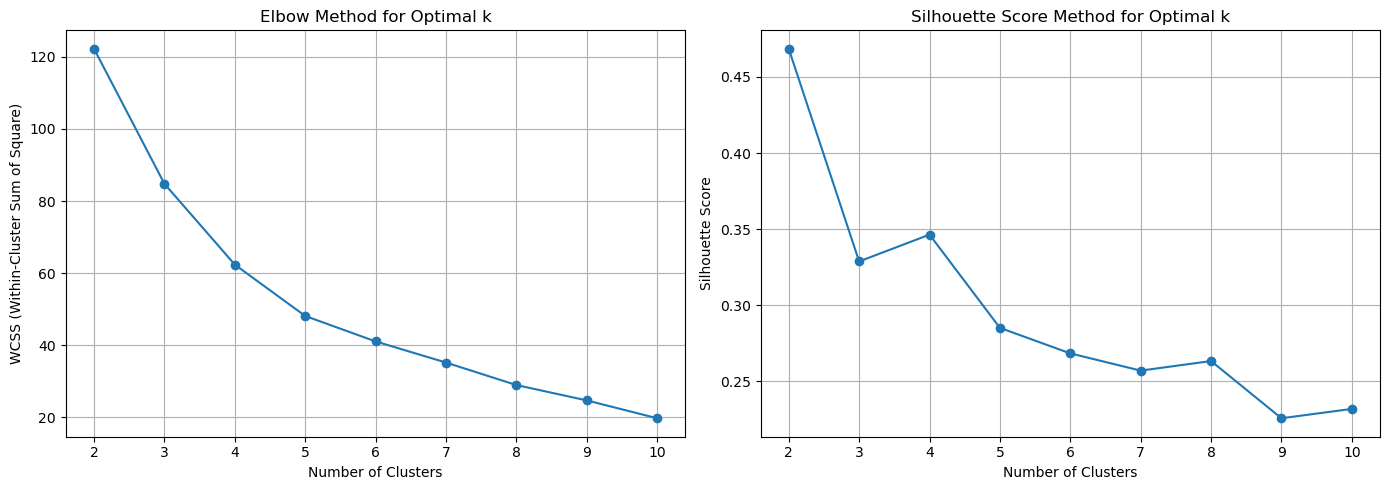

In [30]:
# Determine optimal number of clusters using Elbow Method
max_clusters = 10
wcss = []  # Within-Cluster Sum of Square
silhouette_scores = []

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    if i > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method graph
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Square)')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

For the Elbow Method (Left Plot), we're looking for the “elbow point” where the Within-Cluster Sum of Squares (WCSS) sharply declines and then levels off. In this plot, the elbow appears to be at k = 4 or 5, since the reduction in WCSS starts to become less significant after that point.

For the Silhouette Score (Right Plot), we're looking for the peak silhouette score, as it indicates how well-separated the clusters are. The highest silhouette score is at k = 2, but this might be too coarse for our data and under-cluster. The next highest silhouette score is at k = 4, suggesting a good balance of separation and detail.

From this theoretical analysis, we can conclude that k = 4 is the most suitable choice because it is near the elbow point and it has a relatively high silhouette score compared to others.

However, after testing different cluster sizes and reviewing relevant literature works, we believe that k=3 may actually be the more logical choice. While k = 4 might give a marginally better fit statistically, the fourth cluster may not correspond to a clearly distinct or interpretable state and might also pick up on noise that isn't clinically significant. At k = 3, the silhouette score is still relatively high, indicating reasonably well-separated clusters, and grouping into three clusters like “good,” “moderate,” and “poor” sleep quality is a natural and clinically useful classification.


### 5. K-means Clustering with Dimensionality Reduction

This section applies K-means clustering using the optimal number of clusters (k=3) determined from the previous analysis:

1. **K-means implementation** groups patients based on their EEG features
   - Using k-means++ initialization for more robust clustering
   - Assigns each patient to one of the 3 identified clusters

2. **Principal Component Analysis (PCA)** reduces the 7-dimensional feature space to 2D for visualization
   - Preserves the maximum amount of variance in the data
   - Allows us to see patient distribution in a 2D scatter plot

3. **Visualization of clusters** with scatter plot showing:
   - Patient distribution across the principal components
   - Clear patient ID labels for each data point
   - Color-coding by cluster assignment

4. **Export of results** to Excel for further analysis and sharing

The resulting plot shows how patients naturally group together based on their EEG characteristics, with similar patients appearing closer together in the reduced feature space.

Patient cluster assignments:
   Patient_ID  Cluster
0          49        0
1          46        0
2          37        2
3          24        2
4          64        1
5          15        0
6          73        0
7          11        0
8          63        0
9          12        0
10         27        0
11         59        0
12         74        2
13         45        0
14         34        2
15         50        0
16          5        2
17         32        0
18         43        0
19          1        2
20         76        1
21         29        0
22         18        0
23          2        0
24         31        0
25         40        0
26          6        2
27         22        2
28         13        0


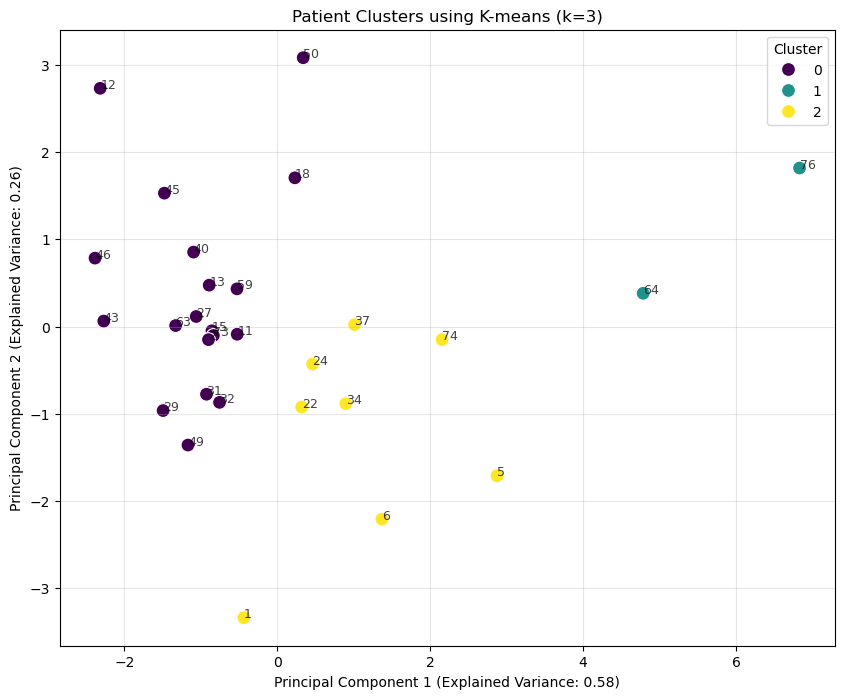

In [31]:
# Perform K-means with optimal number of clusters
# Using the optimal k determined from previous graphs
optimal_k = 3 

# Apply K-means
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Create a DataFrame with patient IDs and their cluster assignments
cluster_df = pd.DataFrame({
    'Patient_ID': patient_ids,
    'Cluster': cluster_labels
})
print("Patient cluster assignments:")
print(cluster_df)

# Apply PCA for visualization 
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels
pca_df['Patient_ID'] = patient_ids

# Visualize the clusters using PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, s=100)

# Add patient IDs as labels
for i, txt in enumerate(patient_ids):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), 
                 fontsize=9, alpha=0.75)

plt.title(f'Patient Clusters using K-means (k={optimal_k})')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.show()

# Export cluster assignments to Excel
cluster_df.to_excel("patient_cluster_assignments.xlsx", index=False)

### 6. Exploring feature distributions with multiple visualization methods

This section performs in-depth analysis of the identified clusters through multiple visualization approaches:

1. **Feature means by cluster** visualized as a heatmap
   - Shows the average value of each EEG feature within each cluster
   - Reveals characteristic patterns that define each patient group
   - Color intensity indicates feature magnitude (darker = higher values)

2. **Cluster size distribution** shown as a bar plot
   - Shows how many patients are assigned to each cluster
   - Helps identify if clusters are balanced or if certain phenotypes are more common

3. **Standardized feature analysis** with a heat map showing deviation from overall mean
   - Red/blue colors show which features are notably higher/lower than average in each cluster
   - Helps identify the most distinctive EEG characteristics of each patient group

4. **Individual feature distributions** explored with boxplots
   - Shows spread, median, and outliers for each feature by cluster
   - Visualizes variance within clusters and separation between clusters

5. **Spindle frequency analysis** specifically examining slow and fast spindles per minute
   - Compares detailed spindle characteristics across clusters
   - Provides statistical summaries for these key diagnostic measures

Together, these visualizations provide a comprehensive understanding of the neurophysiological differences between patient clusters.


Cluster mean values for each feature:
         SWA_All_0.6_1Hz  SWA_All_0.6_4Hz  SWA_Frontal_0.6_1Hz  \
Cluster                                                          
0              14.397909        37.943892            16.035260   
1              65.270001       164.415838            76.686814   
2              26.677463        67.721869            30.385229   

         SWA_Frontal_0.6_4Hz  Avg_Slow_Spindles  Avg_Fast_Spindles  \
Cluster                                                              
0                  40.461784         782.064073         316.610984   
1                 191.933744         690.673913          97.695652   
2                  74.301440         400.826087         236.505435   

         Avg_Total_Spindles  
Cluster                      
0               1098.675057  
1                788.369565  
2                637.331522  


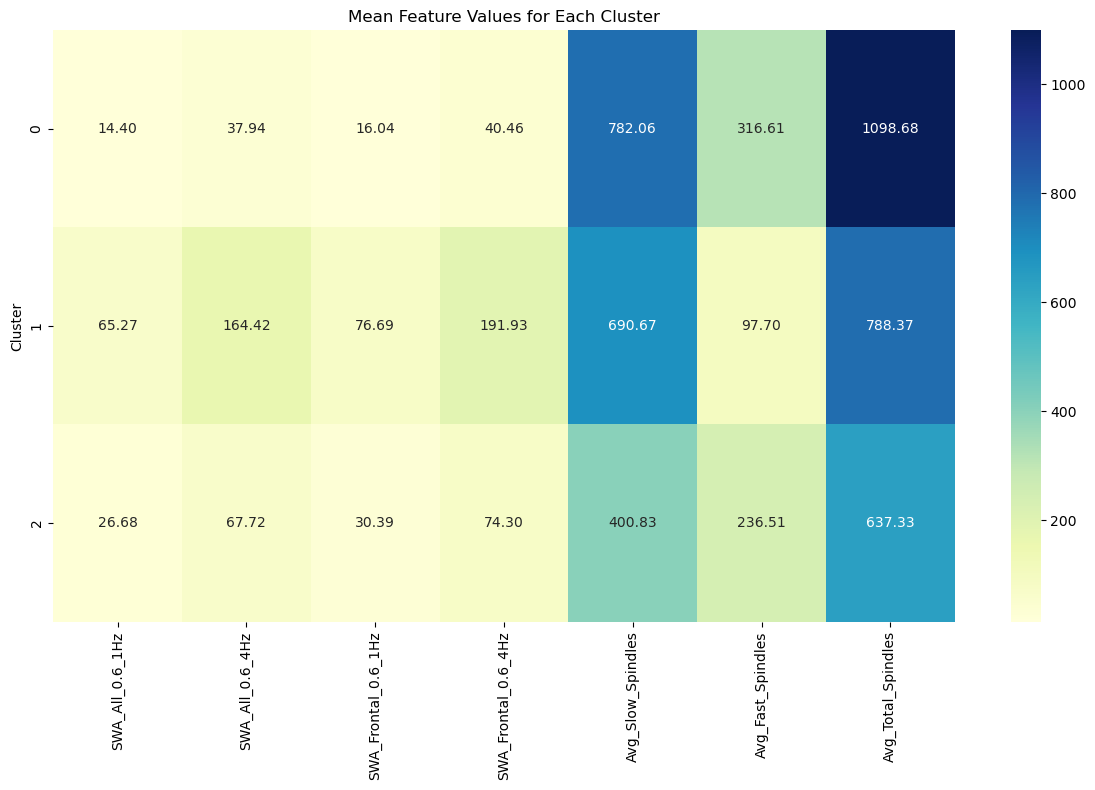


Number of patients in each cluster:
Cluster
0    19
1     2
2     8
Name: count, dtype: int64


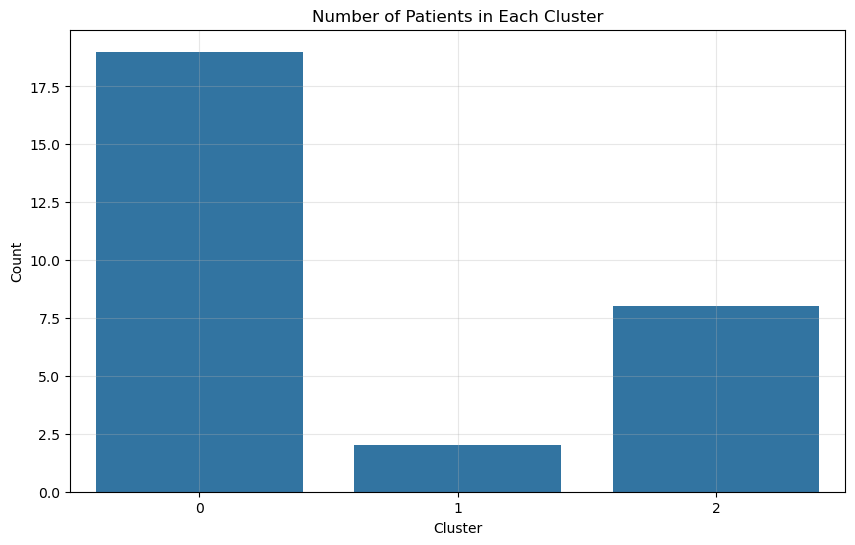

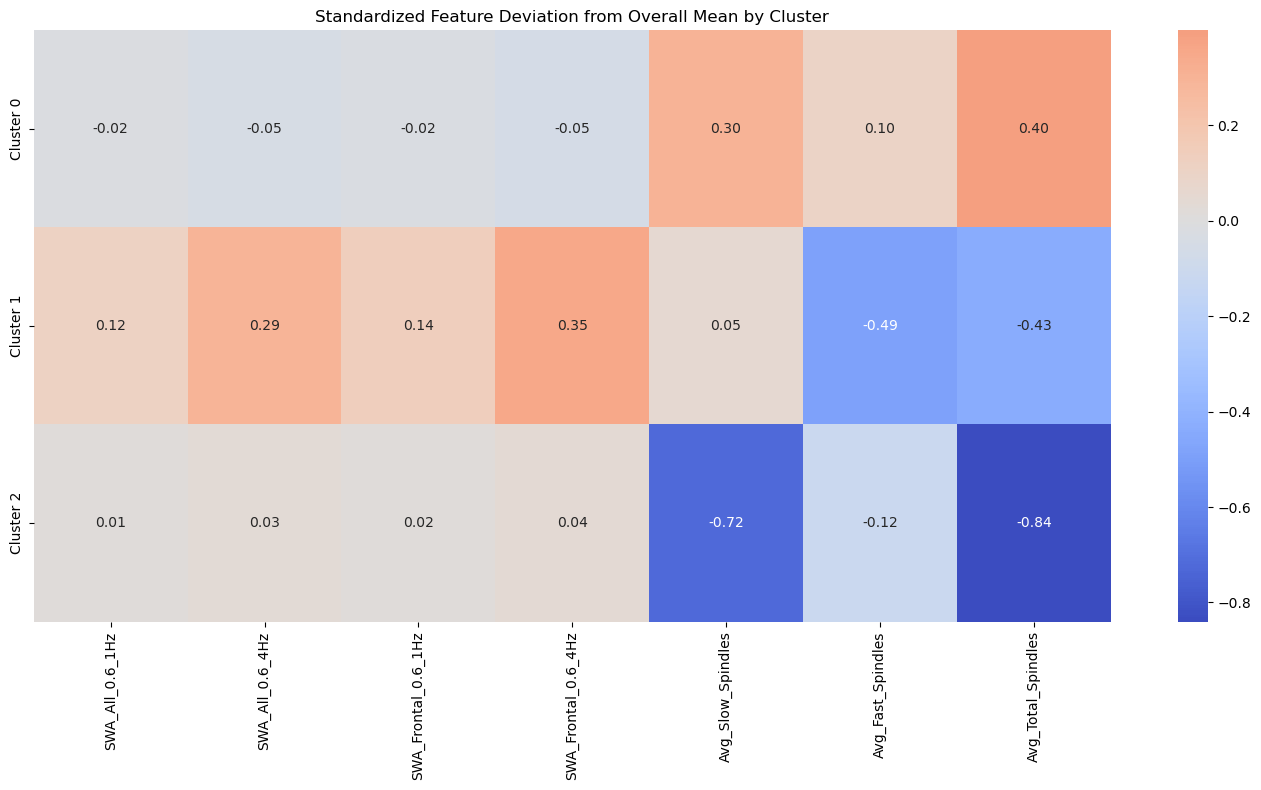


Standard deviation of features within each cluster:
         SWA_All_0.6_1Hz  SWA_All_0.6_4Hz  SWA_Frontal_0.6_1Hz  \
Cluster                                                          
0               7.349220        15.469088             9.031788   
1              12.688533         8.925477            25.348784   
2              12.091537        24.246043            11.004882   

         SWA_Frontal_0.6_4Hz  Avg_Slow_Spindles  Avg_Fast_Spindles  \
Cluster                                                              
0                  17.087364         202.895024         197.172957   
1                  39.879641         145.817716          34.371538   
2                  20.519228         134.313260         111.656181   

         Avg_Total_Spindles  
Cluster                      
0                240.261201  
1                111.446177  
2                222.764540  


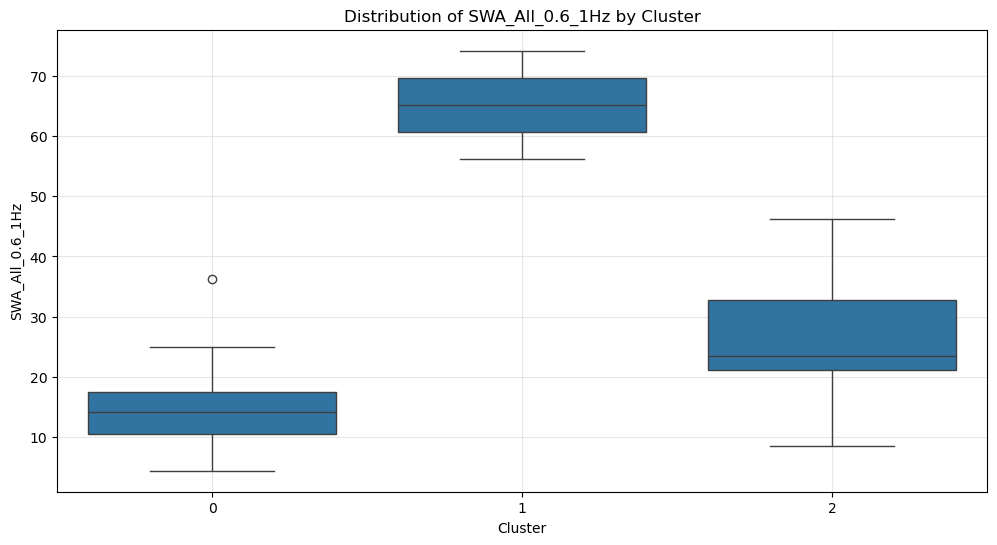

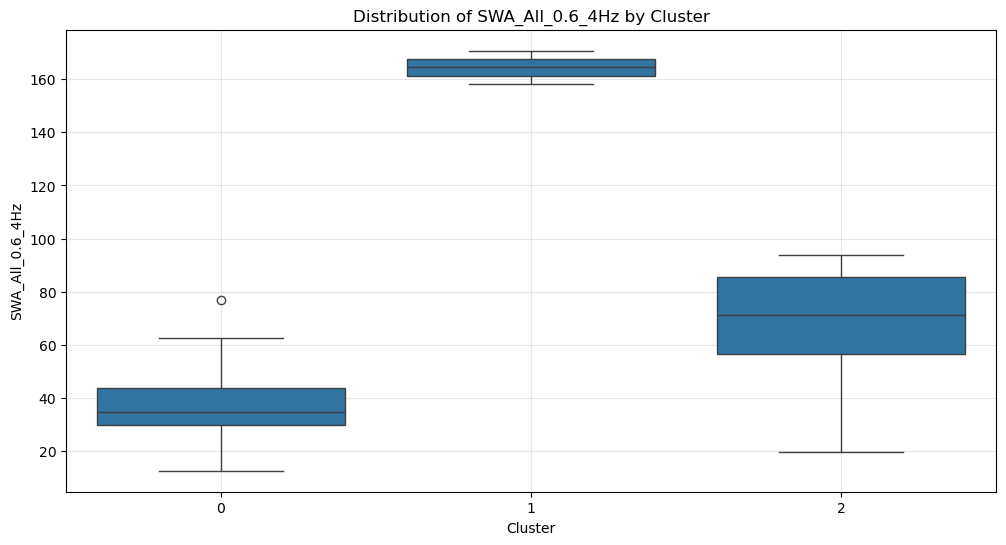

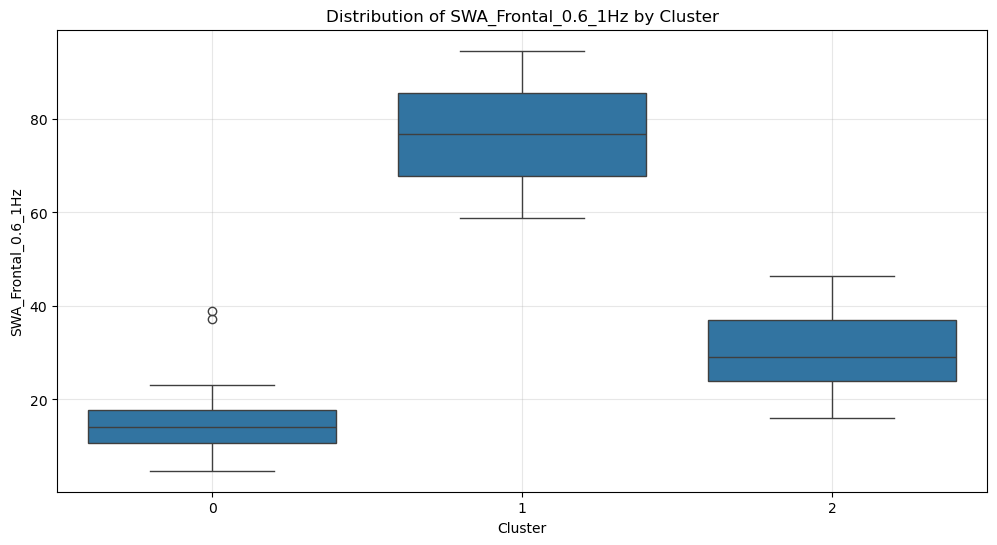

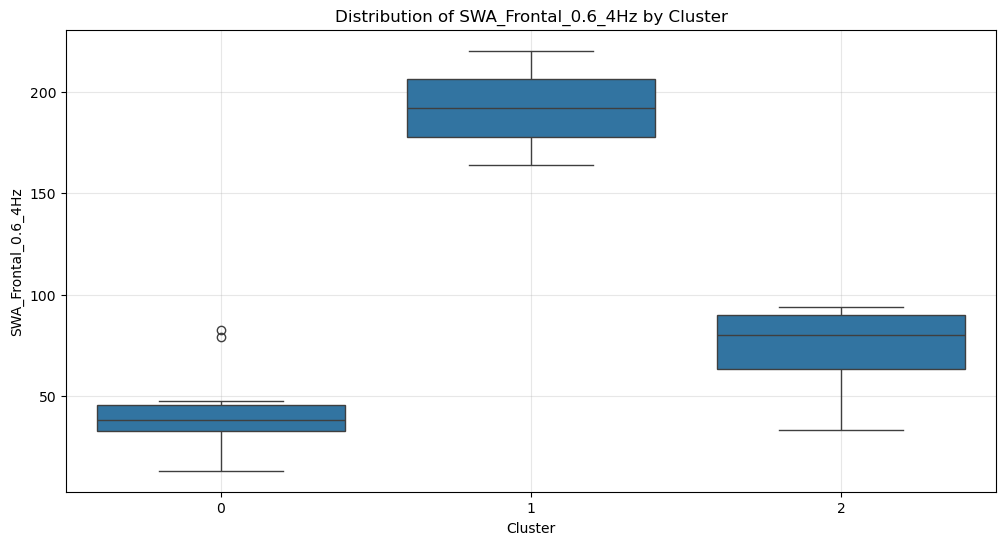

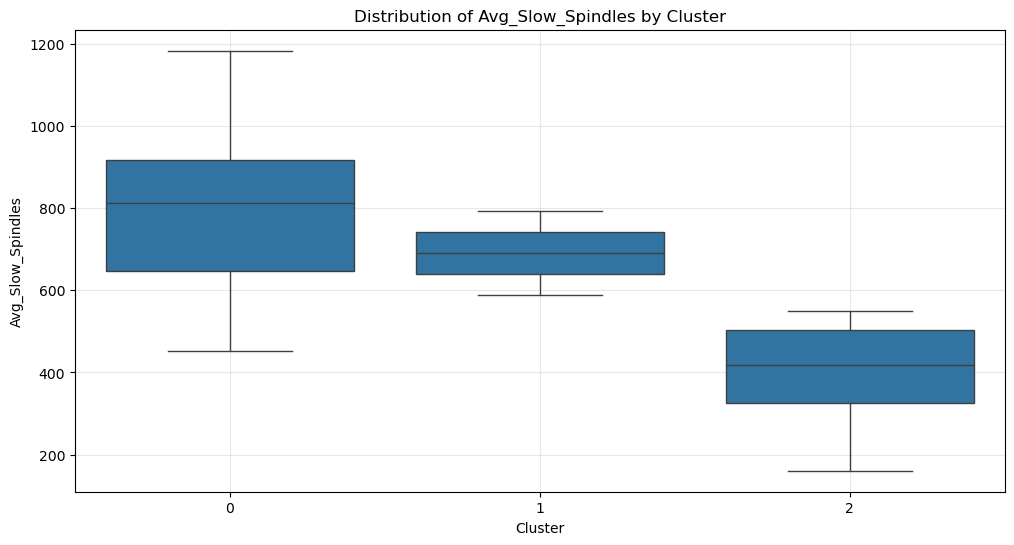

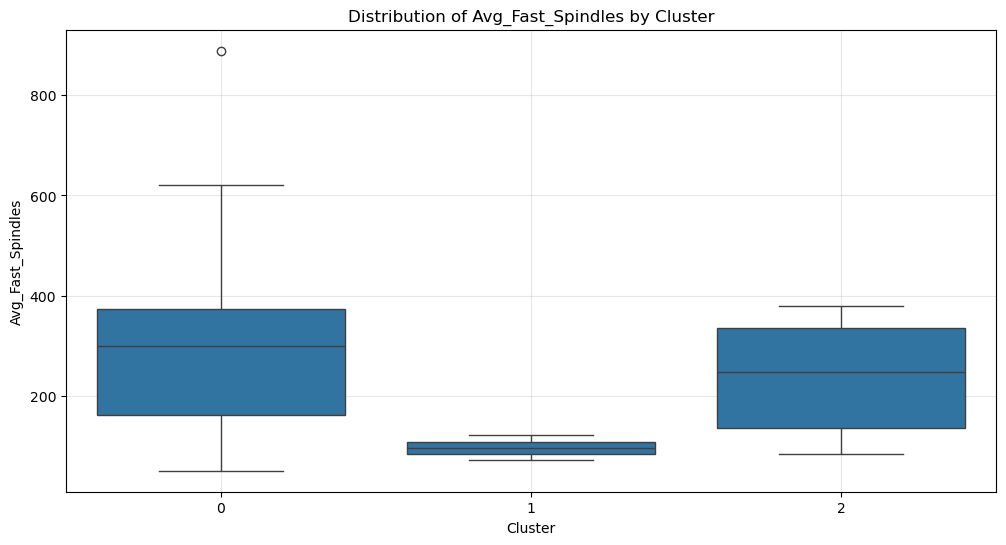

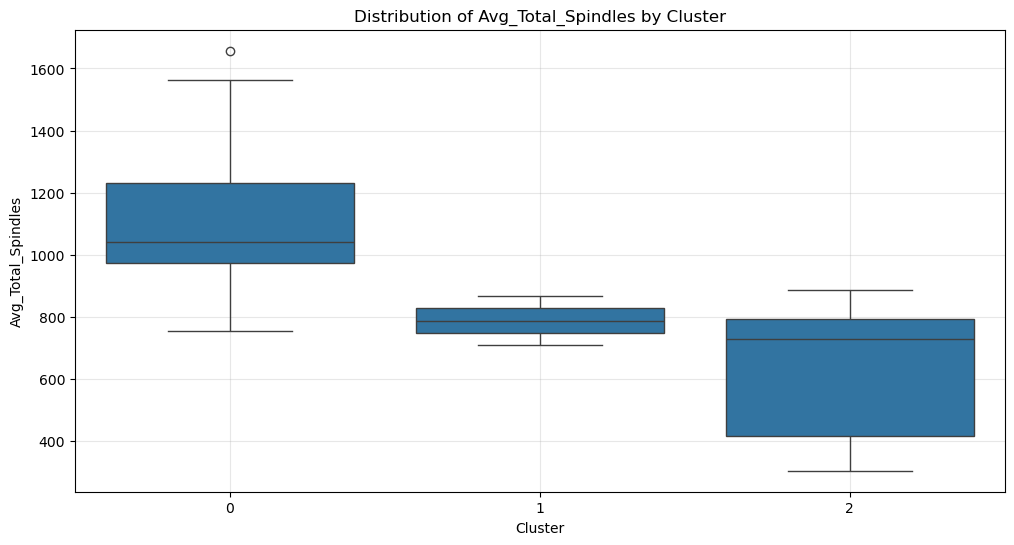

Spindle per minute data by patient and cluster:


,Patient_ID,Cluster,SlowPerMin,FastPerMin
0,49,0,3.155582,2.095440
1,46,0,3.339130,1.829814
2,37,2,2.212153,1.353414
3,24,2,1.741415,1.172314
4,64,1,3.742454,0.777070


/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_29860/3133433506.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='SlowPerMin', data=spindle_per_min_df, ax=axes[0], palette='viridis')
/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_29860/3133433506.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='FastPerMin', data=spindle_per_min_df, ax=axes[1], palette='viridis')


<Figure size 1500x700 with 0 Axes>

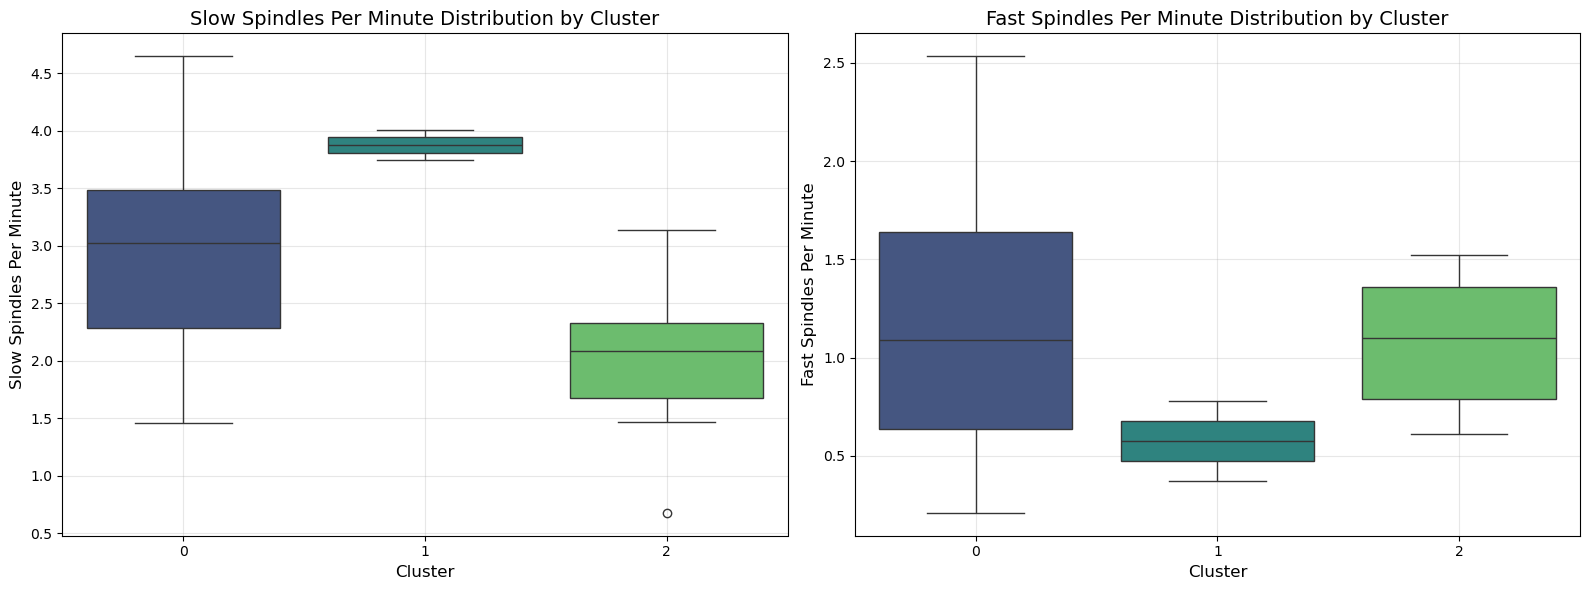


Slow Spindles Per Minute - Summary Statistics by Cluster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,19.0,2.950765,0.888891,1.462451,2.281657,3.023324,3.487842,4.648440
1,2.0,3.875728,0.188479,3.742454,3.809091,3.875728,3.942366,4.009003
2,8.0,2.008123,0.745791,0.677490,1.673404,2.082489,2.324553,3.137818



Fast Spindles Per Minute - Summary Statistics by Cluster:


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,19.0,1.155276,0.632570,0.209968,0.639396,1.089743,1.641217,2.534516
1,2.0,0.573867,0.287373,0.370663,0.472265,0.573867,0.675468,0.777070
2,8.0,1.078372,0.330026,0.611264,0.788872,1.100767,1.357359,1.524266


In [32]:
# Add original features to the cluster dataframe
cluster_analysis = pd.DataFrame(X, columns=['SWA_All_0.6_1Hz', 'SWA_All_0.6_4Hz', 
                                            'SWA_Frontal_0.6_1Hz', 'SWA_Frontal_0.6_4Hz',
                                            'Avg_Slow_Spindles', 'Avg_Fast_Spindles', 'Avg_Total_Spindles'])
cluster_analysis['Patient_ID'] = patient_ids
cluster_analysis['Cluster'] = cluster_labels

# Get mean values of each feature per cluster - exclude Patient_ID from the calculation
numeric_cols = ['SWA_All_0.6_1Hz', 'SWA_All_0.6_4Hz', 'SWA_Frontal_0.6_1Hz', 'SWA_Frontal_0.6_4Hz',
                'Avg_Slow_Spindles', 'Avg_Fast_Spindles', 'Avg_Total_Spindles']
cluster_means = cluster_analysis.groupby('Cluster')[numeric_cols].mean()
print("\nCluster mean values for each feature:")
print(cluster_means)

# Visualize cluster characteristics with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mean Feature Values for Each Cluster')
plt.tight_layout()
plt.show()

# Count number of patients in each cluster
cluster_counts = cluster_analysis['Cluster'].value_counts().sort_index()
print("\nNumber of patients in each cluster:")
print(cluster_counts)

# Plot the distribution of patients across clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Number of Patients in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Additional analysis: Feature importance by cluster
# Calculate standardized differences from overall mean for each cluster
overall_means = cluster_analysis[numeric_cols].mean()
cluster_std_diffs = pd.DataFrame()

for cluster in sorted(cluster_analysis['Cluster'].unique()):
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster][numeric_cols]
    cluster_mean = cluster_data.mean()
    std_diff = (cluster_mean - overall_means) / overall_means.std()
    cluster_std_diffs[f'Cluster {cluster}'] = std_diff

# Plot feature importance heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_std_diffs.T, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Standardized Feature Deviation from Overall Mean by Cluster')
plt.tight_layout()
plt.show()

# Calculate and display standard deviation within each cluster
cluster_stds = cluster_analysis.groupby('Cluster')[numeric_cols].std()
print("\nStandard deviation of features within each cluster:")
print(cluster_stds)

# Visualize feature distributions by cluster with boxplots
for feature in numeric_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Cluster', y=feature, data=cluster_analysis)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()

# Create boxplots specifically for SlowPerMin and FastPerMin across clusters

# First, extract these metrics for each patient and add to a new DataFrame
spindle_per_min_df = pd.DataFrame()

for patient_id, cluster_label in zip(patient_ids, cluster_labels):
    if patient_id in all_patient_data and all_patient_data[patient_id]['spindles'] is not None:
        # Get spindle data for this patient
        spindle_data = all_patient_data[patient_id]['spindles']
        
        # Extract SlowPerMin and FastPerMin rows
        slow_per_min_row = spindle_data[spindle_data['Electrode'] == 'SlowPerMin']
        fast_per_min_row = spindle_data[spindle_data['Electrode'] == 'FastPerMin']
        
        # Check if we have these metrics
        if len(slow_per_min_row) > 0 and len(fast_per_min_row) > 0:
            # Calculate mean across channels (excluding the first 'Electrode' column)
            avg_slow_per_min = slow_per_min_row.iloc[:, 1:].values.mean()
            avg_fast_per_min = fast_per_min_row.iloc[:, 1:].values.mean()
            
            # Add to DataFrame
            patient_row = pd.DataFrame({
                'Patient_ID': [patient_id],
                'Cluster': [cluster_label],
                'SlowPerMin': [avg_slow_per_min],
                'FastPerMin': [avg_fast_per_min]
            })
            spindle_per_min_df = pd.concat([spindle_per_min_df, patient_row], ignore_index=True)

# Display the DataFrame
print("Spindle per minute data by patient and cluster:")
display(spindle_per_min_df.head())

# Create boxplots for both metrics side by side
plt.figure(figsize=(15, 7))

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot SlowPerMin boxplot
sns.boxplot(x='Cluster', y='SlowPerMin', data=spindle_per_min_df, ax=axes[0], palette='viridis')
axes[0].set_title('Slow Spindles Per Minute Distribution by Cluster', fontsize=14)
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Slow Spindles Per Minute', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot FastPerMin boxplot
sns.boxplot(x='Cluster', y='FastPerMin', data=spindle_per_min_df, ax=axes[1], palette='viridis')
axes[1].set_title('Fast Spindles Per Minute Distribution by Cluster', fontsize=14)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Fast Spindles Per Minute', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a summary table of spindle per minute statistics by cluster
print("\nSlow Spindles Per Minute - Summary Statistics by Cluster:")
display(spindle_per_min_df.groupby('Cluster')['SlowPerMin'].describe())

print("\nFast Spindles Per Minute - Summary Statistics by Cluster:")
display(spindle_per_min_df.groupby('Cluster')['FastPerMin'].describe())

### 7. Hierarchical Clustering Analysis

This section applies hierarchical clustering as an alternative to K-means, using the Ward linkage method:

1. **Hierarchical clustering** builds a tree-like structure (dendrogram) that shows:
   - How patients group together at different similarity thresholds
   - The nested structure of relationships between patients
   - The relative distances between merged clusters

2. **Dendrogram visualization** provides insights about:
   - Natural groupings in the data that might not be captured by K-means
   - The hierarchical relationship between patients (which patients are most similar)
   - Potential sub-clusters within larger clusters

3. **Silhouette score analysis** evaluates the quality of hierarchical clustering at different cluster counts
   - Measures how well-separated the resulting clusters are
   - Helps identify the optimal number of clusters in hierarchical clustering
   - Allows direct comparison with K-means clustering performance

4. **Cophenetic correlation** measures how well the dendrogram preserves the original distances
   - Higher values (closer to 1.0) indicate better representation
   - Helps validate the quality of the hierarchical clustering

The horizontal dotted line on the dendrogram represents the threshold used to define the clusters.

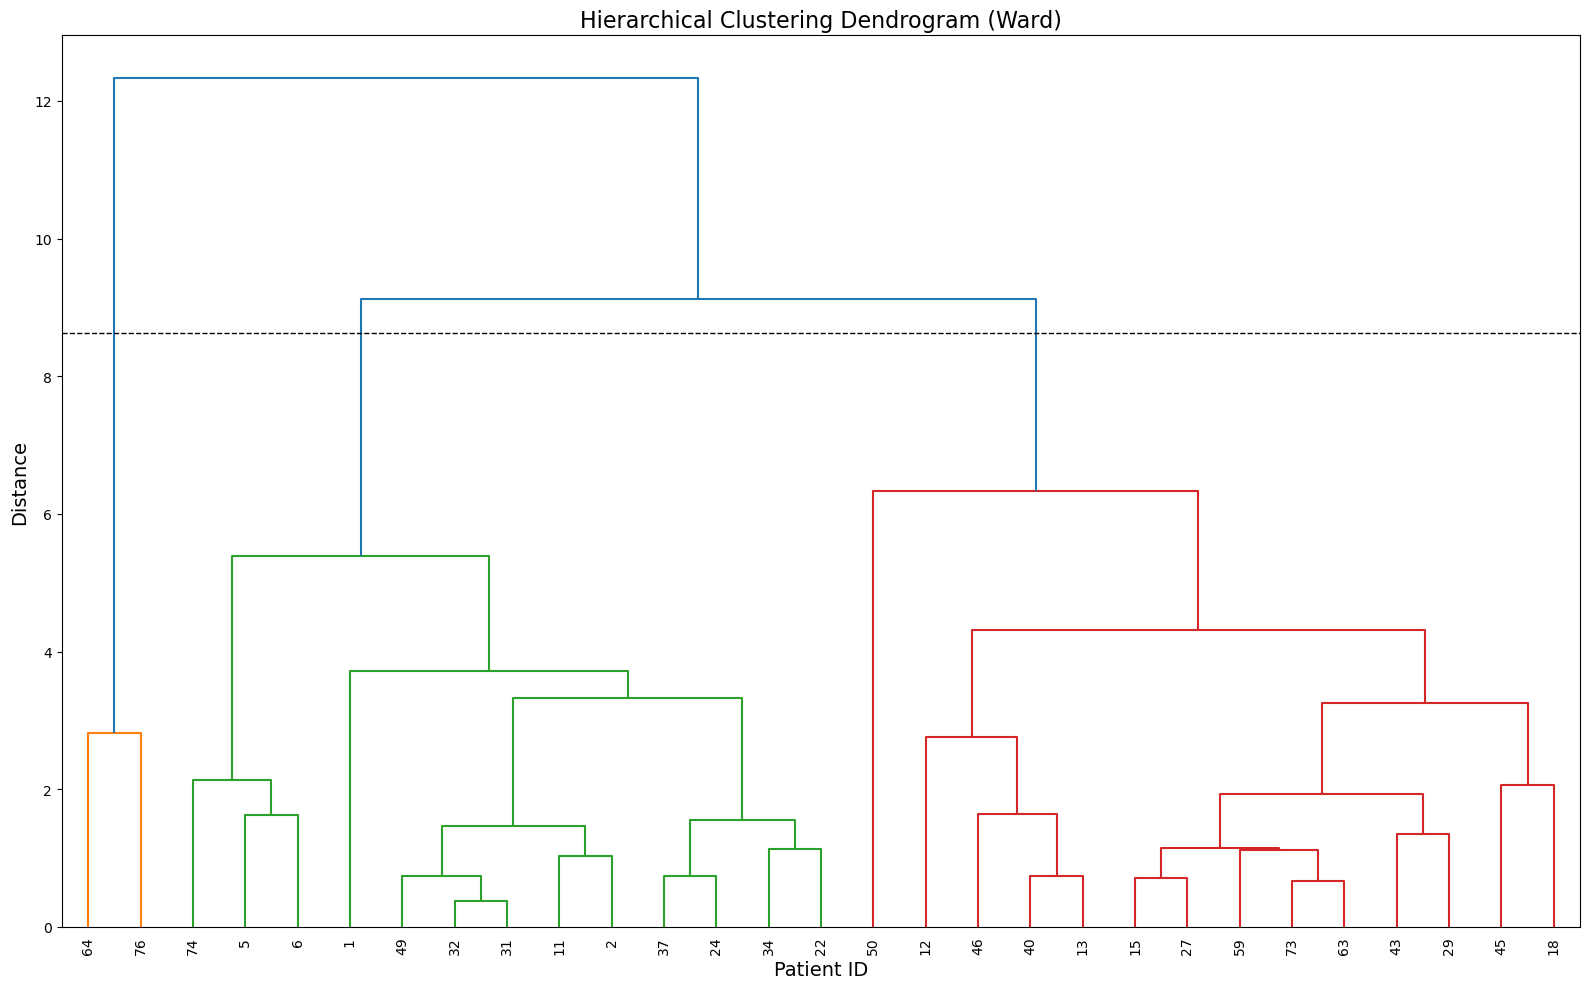

In [33]:
# Import necessary libraries for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

# Compute the linkage matrix
# Ward's method minimizes the variance between clusters (similar to K-means objective)
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(16, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)', fontsize=16)

# Plot the dendrogram with colored threshold
# If we want the same number of clusters as in K-means
dendrogram(Z, labels=patient_ids, leaf_rotation=90, leaf_font_size=10,
           color_threshold=0.7*max(Z[:, 2]))

plt.xlabel('Patient ID', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.axhline(y=0.7*max(Z[:, 2]), c='k', ls='--', lw=1)
plt.tight_layout()
plt.show()

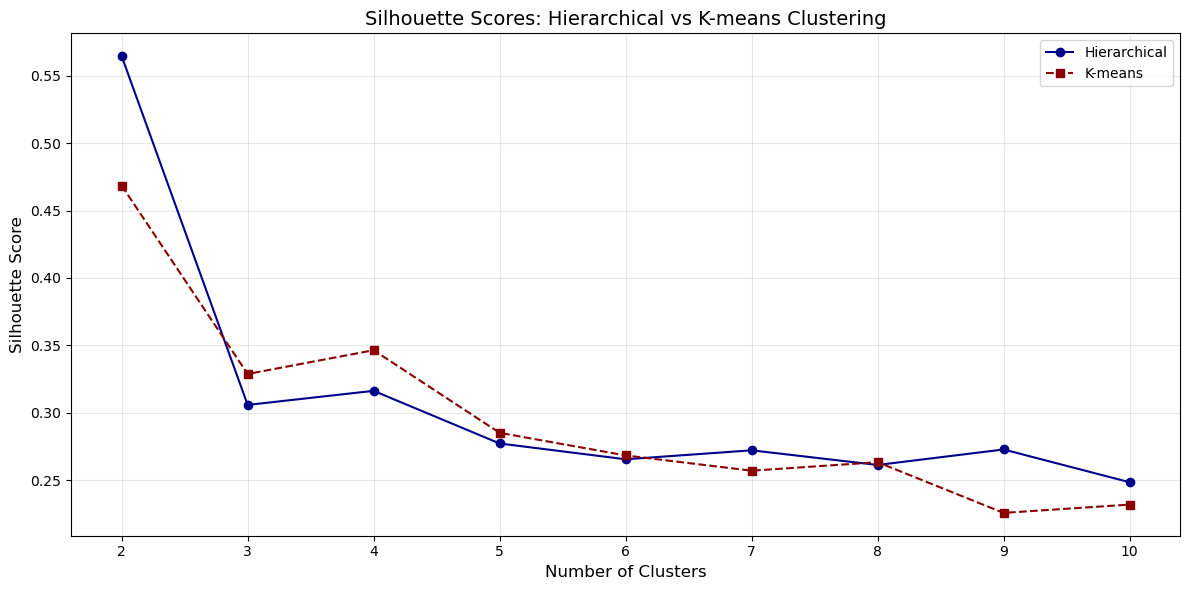

Cophenetic Correlation Coefficient: 0.692
(Higher values indicate better preservation of original distances)

Optimal number of clusters for hierarchical clustering based on silhouette score: 2
Corresponding silhouette score: 0.565


In [34]:
# Calculate silhouette scores for hierarchical clustering with different numbers of clusters
max_clusters = 10
hier_silhouette_scores = []

for i in range(2, max_clusters + 1):
    # Cut the dendrogram to get i clusters
    labels = fcluster(Z, i, criterion='maxclust')
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_scaled, labels)
    hier_silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for hierarchical clustering
plt.figure(figsize=(12, 6))
plt.plot(range(2, max_clusters + 1), hier_silhouette_scores, marker='o', linestyle='-', color='darkblue',
         label='Hierarchical')

# Also add K-means silhouette scores for comparison
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='s', linestyle='--', color='darkred',
         label='K-means')

plt.title('Silhouette Scores: Hierarchical vs K-means Clustering', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range(2, max_clusters + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Cophenetic correlation coefficient
# Measures how faithfully the hierarchical clustering preserves the pairwise distances
c, coph_dists = cophenet(Z, pdist(X_scaled))
print(f"Cophenetic Correlation Coefficient: {c:.3f}")
print("(Higher values indicate better preservation of original distances)")

# Print the optimal number of clusters based on silhouette scores
optimal_hier_k = np.argmax(hier_silhouette_scores) + 2  # +2 because we start from 2 clusters
print(f"\nOptimal number of clusters for hierarchical clustering based on silhouette score: {optimal_hier_k}")
print(f"Corresponding silhouette score: {max(hier_silhouette_scores):.3f}")

In [35]:
# Let's cut the dendrogram to extract the same number of clusters as we used in K-means
hierarchical_labels = fcluster(Z, optimal_k, criterion='maxclust') - 1  # Subtract 1 to start from 0 for consistency with K-means

# Create a DataFrame with patient IDs and their hierarchical cluster assignments
hier_cluster_df = pd.DataFrame({
    'Patient_ID': patient_ids,
    'Hierarchical_Cluster': hierarchical_labels
})

# Compare with K-means clusters
comparison_df = pd.DataFrame({
    'Patient_ID': patient_ids,
    'KMeans_Cluster': cluster_labels,
    'Hierarchical_Cluster': hierarchical_labels
})

display(comparison_df)

# Calculate the agreement percentage between K-means and Hierarchical clustering
# Note: We need to account for the fact that cluster labels might be different but represent the same groups
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# These scores measure the similarity between two clusterings, independent of absolute label values
rand_index = adjusted_rand_score(cluster_labels, hierarchical_labels)
mutual_info = adjusted_mutual_info_score(cluster_labels, hierarchical_labels)

print(f"\nAgreement between K-means and Hierarchical clustering:")
print(f"Adjusted Rand Index: {rand_index:.3f} (1.0 means perfect agreement)")
print(f"Adjusted Mutual Information: {mutual_info:.3f} (1.0 means perfect agreement)")

,Patient_ID,KMeans_Cluster,Hierarchical_Cluster
0,49,0,1
1,46,0,2
2,37,2,1
3,24,2,1
4,64,1,0
5,15,0,2
6,73,0,2
7,11,0,1
8,63,0,2
9,12,0,2



Agreement between K-means and Hierarchical clustering:
Adjusted Rand Index: 0.457 (1.0 means perfect agreement)
Adjusted Mutual Information: 0.566 (1.0 means perfect agreement)


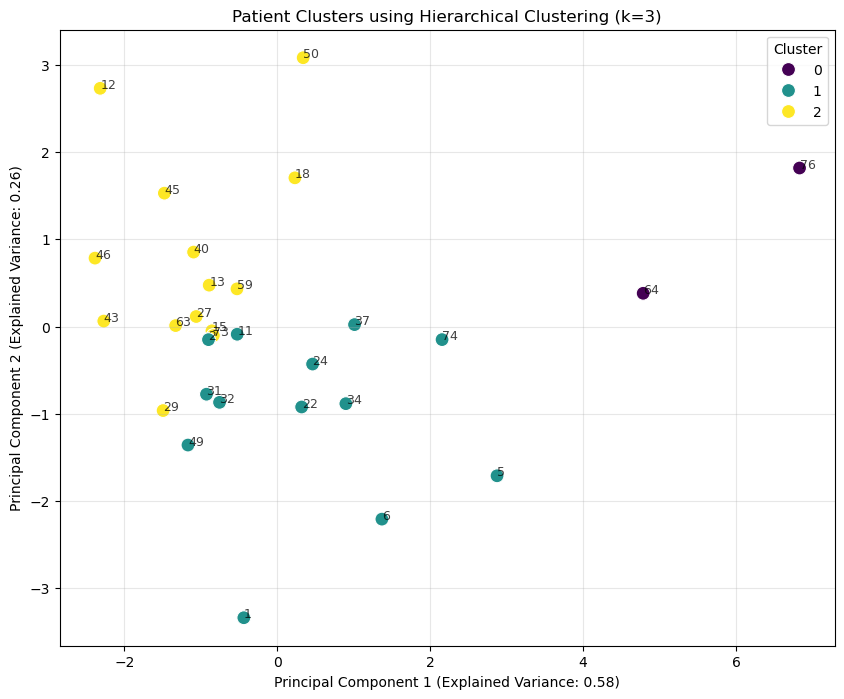


Hierarchical Cluster mean values for each feature:


,SWA_All_0.6_1Hz,SWA_All_0.6_4Hz,SWA_Frontal_0.6_1Hz,SWA_Frontal_0.6_4Hz,Avg_Slow_Spindles,Avg_Fast_Spindles,Avg_Total_Spindles
Cluster,,,,,,,
0,65.270001,164.415838,76.686814,191.933744,690.673913,97.695652,788.369565
1,21.436776,54.892298,24.956179,61.248548,446.204013,283.511706,729.715719
2,14.878706,39.222073,15.951531,40.496735,876.083851,301.571429,1177.655280


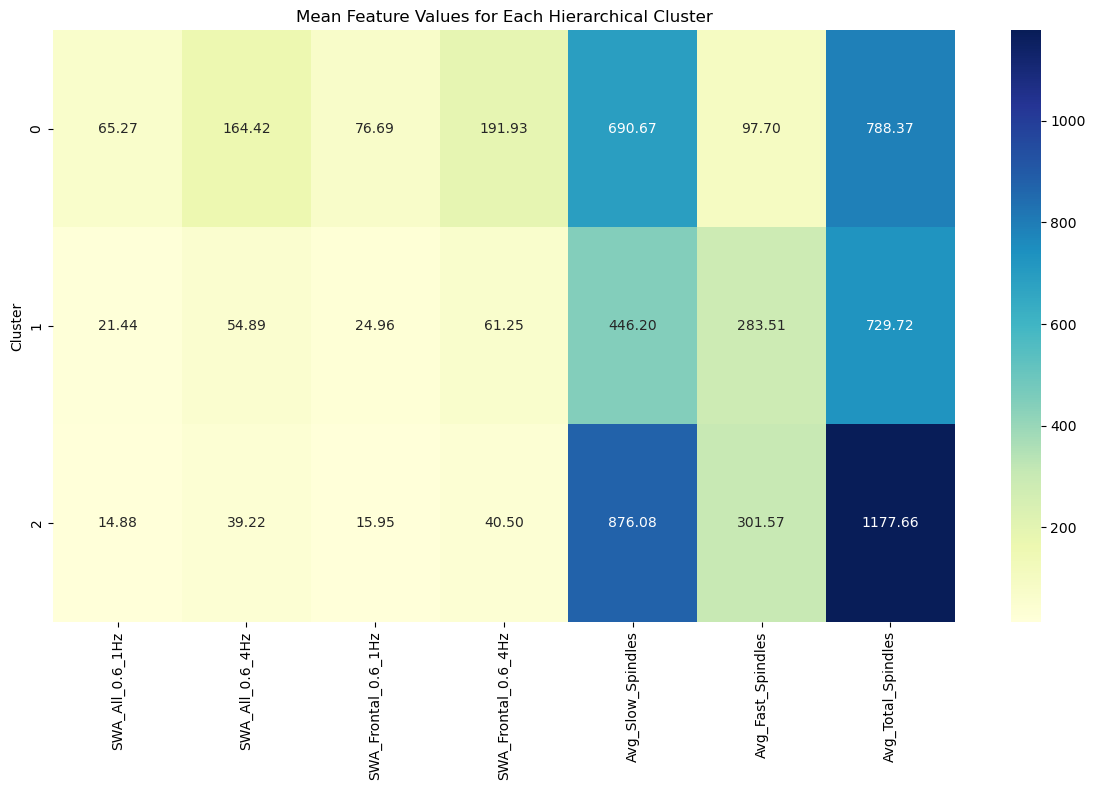


Number of patients in each hierarchical cluster:
Cluster
0     2
1    13
2    14
Name: count, dtype: int64


In [36]:
# Visualize hierarchical clusters using PCA
pca_hier_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_hier_df['Cluster'] = hierarchical_labels
pca_hier_df['Patient_ID'] = patient_ids

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_hier_df, s=100)

# Add patient IDs as labels
for i, txt in enumerate(patient_ids):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), 
                 fontsize=9, alpha=0.75)

plt.title(f'Patient Clusters using Hierarchical Clustering (k={optimal_k})')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.show()

# Create a DataFrame for hierarchical cluster analysis
hier_analysis = pd.DataFrame(X, columns=numeric_cols)
hier_analysis['Patient_ID'] = patient_ids
hier_analysis['Cluster'] = hierarchical_labels

# Calculate mean feature values for each hierarchical cluster
hier_cluster_means = hier_analysis.groupby('Cluster')[numeric_cols].mean()
print("\nHierarchical Cluster mean values for each feature:")
display(hier_cluster_means)

# Create heatmap for hierarchical cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(hier_cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mean Feature Values for Each Hierarchical Cluster')
plt.tight_layout()
plt.show()

# Count patients in each hierarchical cluster
hier_cluster_counts = hier_analysis['Cluster'].value_counts().sort_index()
print("\nNumber of patients in each hierarchical cluster:")
print(hier_cluster_counts)

/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_29860/1946189516.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hierarchical_Cluster', y='SlowPerMin', data=hier_spindle_per_min_df, ax=axes[0], palette='viridis')
/var/folders/xp/nsdfv7c175v6fr_sd8q514780000gn/T/ipykernel_29860/1946189516.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hierarchical_Cluster', y='FastPerMin', data=hier_spindle_per_min_df, ax=axes[1], palette='viridis')


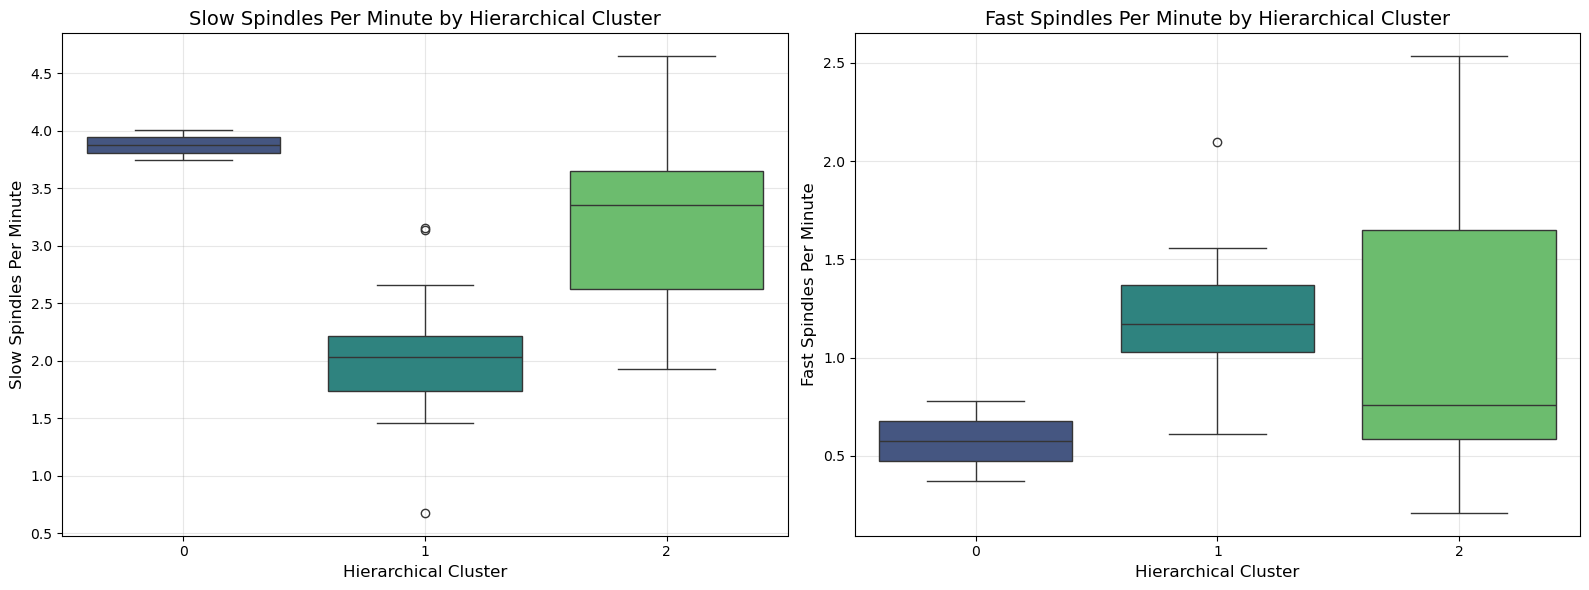


Slow Spindles Per Minute - Summary Statistics by Hierarchical Cluster:


,count,mean,std,min,25%,50%,75%,max
Hierarchical_Cluster,,,,,,,,
0,2.0,3.875728,0.188479,3.742454,3.809091,3.875728,3.942366,4.009003
1,13.0,2.038057,0.680441,0.677490,1.741415,2.030846,2.212153,3.155582
2,14.0,3.259627,0.759722,1.926937,2.625373,3.353229,3.650495,4.648440



Fast Spindles Per Minute - Summary Statistics by Hierarchical Cluster:


,count,mean,std,min,25%,50%,75%,max
Hierarchical_Cluster,,,,,,,,
0,2.0,0.573867,0.287373,0.370663,0.472265,0.573867,0.675468,0.777070
1,13.0,1.213264,0.390520,0.611264,1.029220,1.172314,1.369197,2.095440
2,14.0,1.057485,0.679631,0.209968,0.586687,0.756748,1.648083,2.534516


In [37]:
# Create boxplots for spindle per minute metrics by hierarchical cluster

# Extract these metrics for each patient with hierarchical cluster labels
hier_spindle_per_min_df = pd.DataFrame()

for patient_id, hier_label in zip(patient_ids, hierarchical_labels):
    if patient_id in all_patient_data and all_patient_data[patient_id]['spindles'] is not None:
        # Get spindle data for this patient
        spindle_data = all_patient_data[patient_id]['spindles']
        
        # Extract SlowPerMin and FastPerMin rows
        slow_per_min_row = spindle_data[spindle_data['Electrode'] == 'SlowPerMin']
        fast_per_min_row = spindle_data[spindle_data['Electrode'] == 'FastPerMin']
        
        # Check if we have these metrics
        if len(slow_per_min_row) > 0 and len(fast_per_min_row) > 0:
            # Calculate mean across channels (excluding the 'Electrode' column)
            avg_slow_per_min = slow_per_min_row.iloc[:, 1:].values.mean()
            avg_fast_per_min = fast_per_min_row.iloc[:, 1:].values.mean()
            
            # Add to DataFrame
            patient_row = pd.DataFrame({
                'Patient_ID': [patient_id],
                'Hierarchical_Cluster': [hier_label],
                'SlowPerMin': [avg_slow_per_min],
                'FastPerMin': [avg_fast_per_min]
            })
            hier_spindle_per_min_df = pd.concat([hier_spindle_per_min_df, patient_row], ignore_index=True)

# Create boxplots for both metrics side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot SlowPerMin boxplot by hierarchical cluster
sns.boxplot(x='Hierarchical_Cluster', y='SlowPerMin', data=hier_spindle_per_min_df, ax=axes[0], palette='viridis')
axes[0].set_title('Slow Spindles Per Minute by Hierarchical Cluster', fontsize=14)
axes[0].set_xlabel('Hierarchical Cluster', fontsize=12)
axes[0].set_ylabel('Slow Spindles Per Minute', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot FastPerMin boxplot by hierarchical cluster
sns.boxplot(x='Hierarchical_Cluster', y='FastPerMin', data=hier_spindle_per_min_df, ax=axes[1], palette='viridis')
axes[1].set_title('Fast Spindles Per Minute by Hierarchical Cluster', fontsize=14)
axes[1].set_xlabel('Hierarchical Cluster', fontsize=12)
axes[1].set_ylabel('Fast Spindles Per Minute', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary statistics by hierarchical cluster
print("\nSlow Spindles Per Minute - Summary Statistics by Hierarchical Cluster:")
display(hier_spindle_per_min_df.groupby('Hierarchical_Cluster')['SlowPerMin'].describe())

print("\nFast Spindles Per Minute - Summary Statistics by Hierarchical Cluster:")
display(hier_spindle_per_min_df.groupby('Hierarchical_Cluster')['FastPerMin'].describe())

### 8. Comparing K-means and Hierarchical Clustering Results

This section evaluates the consistency between K-means and hierarchical clustering approaches:

1. **Cluster assignment comparison** creates a side-by-side view of how patients are grouped by each method
   - Shows whether different clustering techniques identify similar patient phenotypes
   - Highlights patients that might be classified differently by the two methods

2. **Adjusted similarity metrics** measure agreement between the two clustering approaches
   - Adjusted Rand Index: Measures similarity between clustering assignments, accounting for chance
   - Adjusted Mutual Information: Quantifies shared information between the two groupings

These metrics help determine if the identified patient groups represent robust neurophysiological phenotypes or if they might be artifacts of the specific clustering algorithm used.

In [38]:
# Load the Excel file
df = pd.read_excel("patient_cluster_assignments.xlsx")

# Map cluster values to sleep quality labels
sleep_quality_map = {
    0: "poor",
    1: "good",
    2: "moderate"
}
df["sleep_quality"] = df["Cluster"].map(sleep_quality_map)

# Save to a new Excel file or overwrite the existing one
df.to_excel("patient_cluster_assignments.xlsx", index=False)